In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [6]:
import xgboost

In [7]:
import category_encoders as ce

In [8]:
import shap
shap.initjs()

In [77]:
import random

In [9]:
import matplotlib.pyplot as plt

In [10]:
import seaborn as sns

In [11]:
%matplotlib inline

### Домашнее задание 07

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### Получение датасета и анализ

В качестве датасета выбран датасет Census-Income  Data Set, предназначенный для классификации.

Список колонок для датасета.

In [12]:
names = ['age', 
'workclass',
'fnlwgt',
'education',
'education-num',
'marital-status',
'occupation',
'relationship',
'race',
'sex',
'capital-gain',
'capital-loss',
'hours-per-week',
'native-country',
'earnings']

получение датасета

In [13]:
df = pd.read_csv("adult.data", names=names, index_col=False)

In [14]:
df[names].head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [15]:
df.shape

(32561, 15)

Разбиваем список колонок на категориальные и непрерывнве переменные для последующего анализа каждой кологки индивидуально.

In [16]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [17]:
continious_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Общая информация по непрерывным переменным.

In [18]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Анализ каждой из непрерывных переменных при помощи боксплот

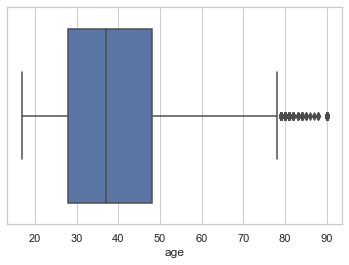

In [19]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df["age"])

In [20]:
df['age'][df['age'] > 80].count()

99

В age имеется некоторое количество выросов,но ввиду их правдоподобности никаких действий над ними проводится не будет.

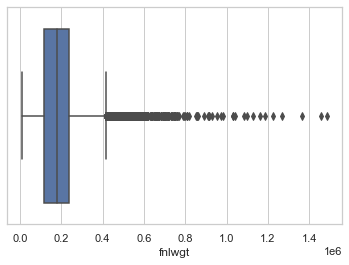

In [21]:
ax = sns.boxplot(x=df["fnlwgt"])

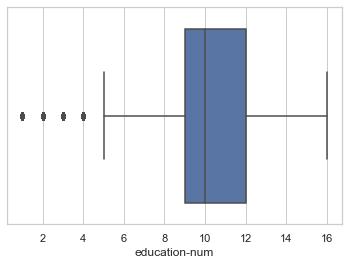

In [22]:
ax = sns.boxplot(x=df["education-num"])

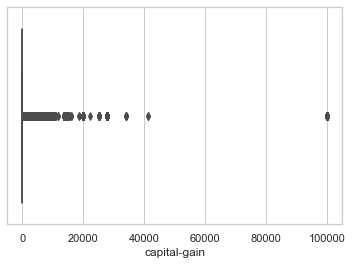

In [23]:
ax = sns.boxplot(x=df["capital-gain"])

<AxesSubplot:>

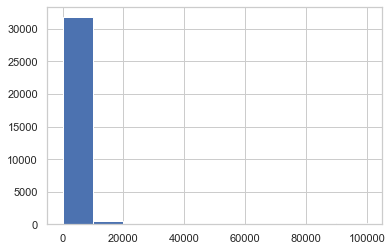

In [24]:
df['capital-gain'].hist()

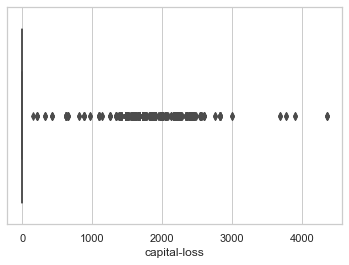

In [25]:
ax = sns.boxplot(x=df["capital-loss"])

<AxesSubplot:>

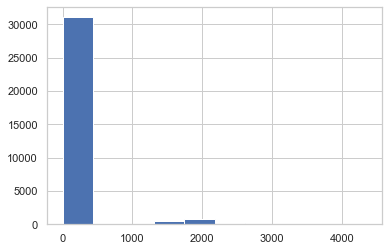

In [26]:
df["capital-loss"].hist()

capital-gain и capital-loss несмотря на очень большой количество выбросов оставляем как есть 

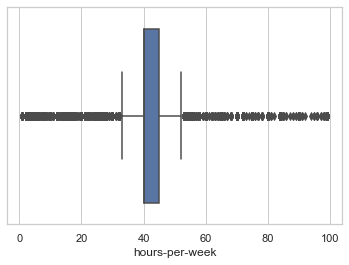

In [27]:
ax = sns.boxplot(x=df["hours-per-week"])

hours-per-week величины, возможно, следует ограничить, как минимум, по верхней величине ввиду крайней сложности работать 80-100 часов в неделю. Возможно, тут имеется едостоверная информация.  
Но в данном датаесете для учебных целей попробуем оставить данные без изменений.

Проверка непрерывных переменных на линейную корреляцию.

<AxesSubplot:>

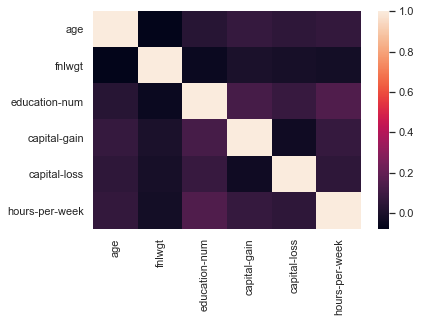

In [28]:
sns.heatmap(df[continious_features].corr())

Диаграмма показывает низкую линейную корреляцию между непрерывными величинами.

##### категориальные переменные.

т.к.  категориальные переменные могут не подчинаятся каким дибо законом распределения, все, чтто можно сделать - это рассмотреть их количественное соотношение ипроверить целевую переменную на дисбаланс классов.

In [29]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='workclass', ylabel='count'>

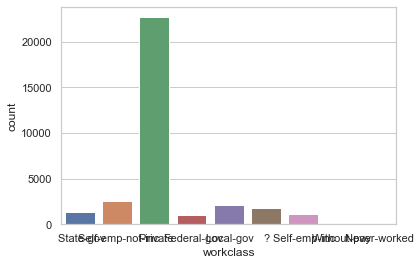

In [30]:
sns.countplot(df['workclass'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='education', ylabel='count'>

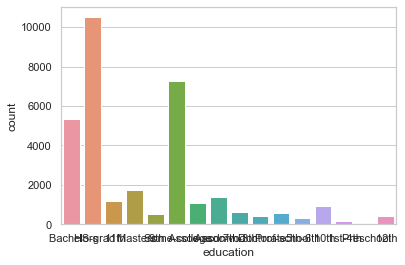

In [31]:
sns.countplot(df['education'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='marital-status', ylabel='count'>

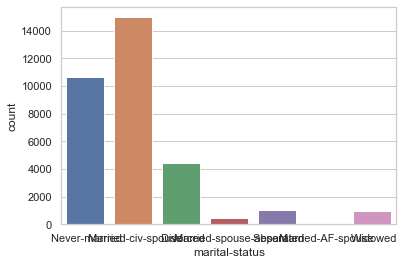

In [32]:
sns.countplot(df['marital-status'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='occupation', ylabel='count'>

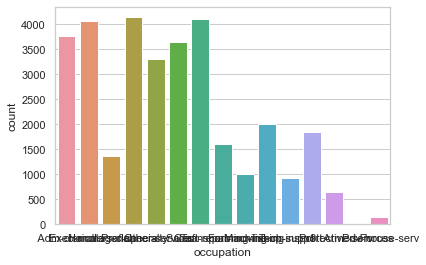

In [33]:
sns.countplot(df['occupation'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='relationship', ylabel='count'>

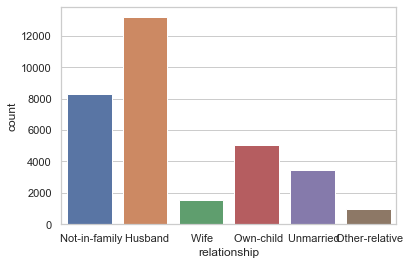

In [34]:
sns.countplot(df['relationship'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='race', ylabel='count'>

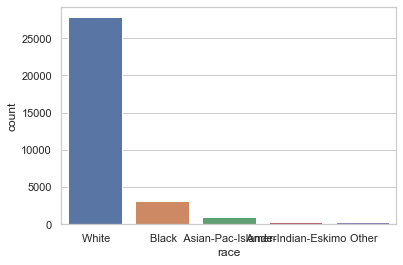

In [35]:
sns.countplot(df['race'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='sex', ylabel='count'>

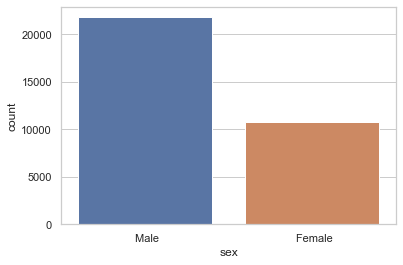

In [36]:
sns.countplot(df['sex'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='native-country', ylabel='count'>

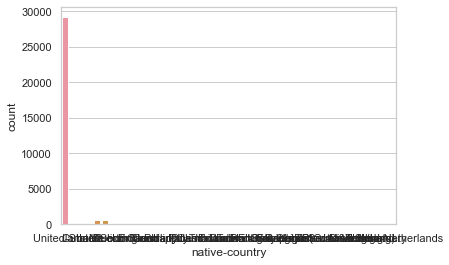

In [37]:
sns.countplot(df['native-country'])

В дальнейшем, сводные данные по категориальным переменным могут быть использованы для проведения выводов о зависимости величины дохода от факторов описывающих конкретного человека и выделения различных групп для социологического анализа.

Обобщенная информация по типам данных в датасете

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  earnings        32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Анализ датасета на null значения

In [39]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
earnings          0
dtype: int64

Анализ целевой переменной.

In [40]:
df['earnings'].value_counts()

 <=50K    24720
 >50K      7841
Name: earnings, dtype: int64

как можно увидеть, имеется определеный дисбаланс классов в соотношении 3:1.  
В дальнейшем может потребоваться ребаланс классов тем или иным методом.

### Feature engineering

Делаем копию датасета, с которой будем работать и проводить трансформации.

In [41]:
X = df.copy()

замена целевой переменной на метки классов.

In [42]:
X.loc[X['earnings'] == ' <=50K', 'earnings'] = 0
X.loc[X['earnings'] == ' >50K', 'earnings'] = 1

In [43]:
X['earnings'] = X['earnings'].astype('int8')

Как было сказано в предыдущем разделе оставим исходные данные без обрезки выбросов.

Т.к. модель xgboost, которая будет применяться в данном случае, основана на деревьях решений балансировка размерностей непрерывных величин при помощи StandardScaler/MinMaxScaler не ребуется.

Применим get_dummies функцию для обработки категориальных переменных

In [44]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [45]:
X_p = X[cat_features]

Используем get_dummies функцию для обработки датасета.

In [46]:
X_p.columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [47]:
#encoder = ce.BackwardDifferenceEncoder(cols=cat_features)

In [48]:
#X = encoder.fit_transform(X)

In [49]:
#for i in range(X_p.shape[1]):
#    X[cat_features[i]] = X_p[cat_features[i]].astype('category').cat.codes    

In [50]:
#for i in range(X_p.shape[1]):
#    X[cat_features[i]] = X_p[cat_features[i]].astype('category').cat.codes    

In [51]:
#X.head()

In [52]:
X_p = pd.get_dummies(X_p)

In [53]:
X = X.drop(cat_features, axis = 1)

In [54]:
X = X.merge(X_p, left_index=True, right_index=True)

In [55]:
X.shape

(32561, 109)

Разделим датасет на обучающую и тестовую выборки.

In [56]:
y = X['earnings']

In [57]:
X = X.drop('earnings', axis = 1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Обучение модели

Воспользуемся моделью xgboost для обучения.

In [59]:
clf = xgboost.train(  {"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)


Построим график важности признаков для первых десяти признаков (с учетом дамми преобразования)

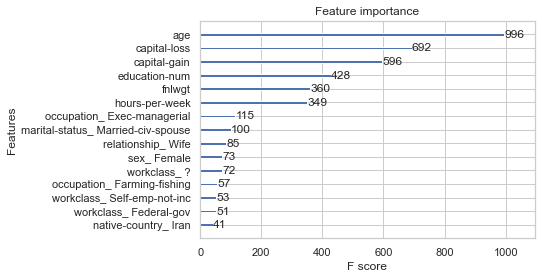

In [60]:
xgboost.plot_importance(clf, 
                       grid=True,
                       max_num_features = 15)
plt.show()

### SHAP

строим модель SHAP

In [61]:
explainer = shap.TreeExplainer(clf)

In [62]:
shap_values = explainer.shap_values(X_train)

Важность признаков для всего суммарного набора данных.

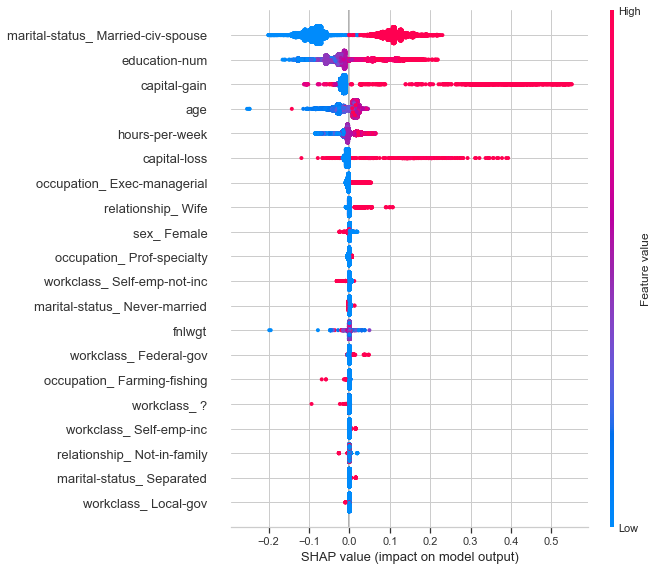

In [63]:
shap.summary_plot(shap_values, X_train)

Средние значения SHAP для каждого признака.

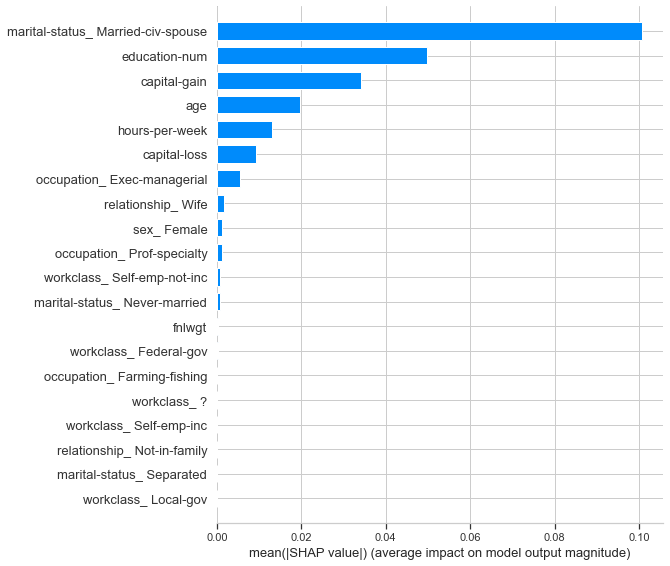

In [64]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

**Вывод**  
Из графиков можно сделать вывод, что из категориальных признаков значение имеют только определенные значения, но не все признаки в целом.
Также в чисе самых важных признаков сохранились непрерывные переменные.  
Примечательно, что важность признака в xgboost и в shap не совпадают.

In [65]:
shap_values_all = explainer(X_train.iloc[:,:])

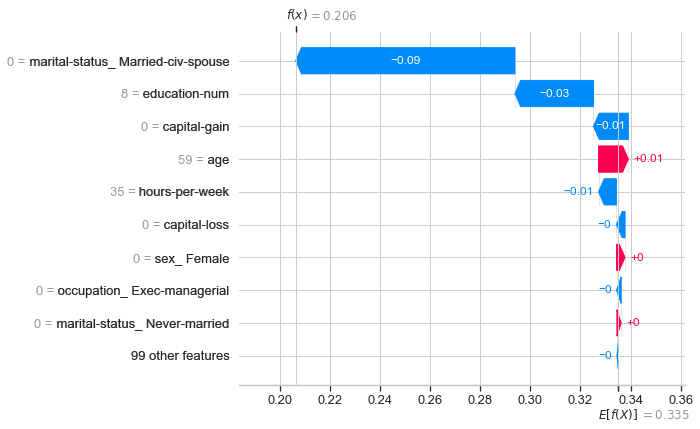

In [66]:
shap.plots.waterfall(shap_values_all[0])

Если исключить искуственно разбитые категоиальные признаки наибольшее влияние на целевую переменную оказывает поле Age. С возрастанием Age увеличивается вероятность получения класса 1.  
Если же учитывать категориальные признаки, преобразованные при помощи get_dummies, то можно сделать вывод, чтоопрделенный семейный статус и образование снижают вероятность получения класса 1 в значительной степени.  
Также, можно отметить, что часть признаков, например, класс работ, практически не влияют на основную переменную. Т.е. при дальнейшем анализе датасета часть признаков можно исключить, не ожидая, при этом значительного ухудшения величины метрик.  
Хотелось бы отметить, что картина показываемая SHAP отличается, от данных предоставленных при обучении модели.

In [67]:
n = 6
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

Средняя величина влияния признака на целевую переменную.

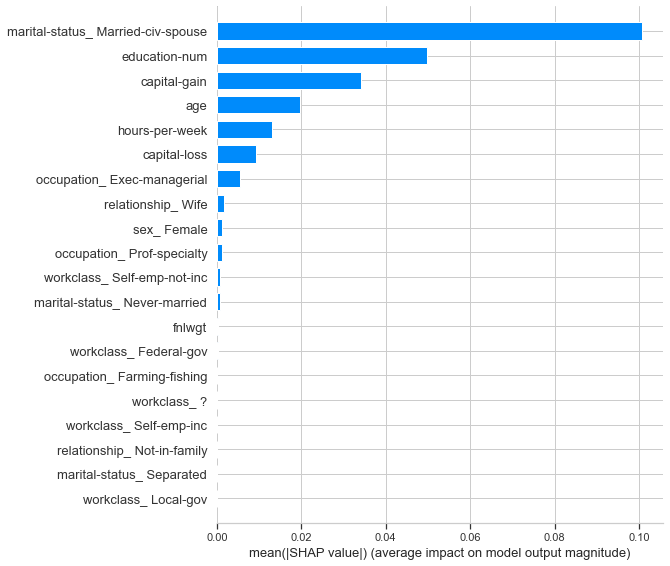

In [68]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Вывод данных для отдельных наблюдений

In [73]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[n,:], link="logit")

Данное значение лпределяется влиянием возраста, который в данном случае играет роль величины увеличивающей значение, и в порядке убывания по влиянию величин семейного статуса, образования, пробретенного капитала и среднего количесва часов работы в неделю.

In [89]:
n = random.randint(0, X_test.shape[0]-1)
n

979

In [90]:
shap.force_plot(explainer.expected_value, shap_values[n,:], X_train.iloc[n,:])